# Introducción al Aprendizaje Automatizado

## Trabajo Práctico Nro 3

## Inés Cipullo

### 2023

## Ejercicio 1

### Código Auxiliar

In [ ]:
import numpy as np
import pandas as pd


class MultidimensionalGaussianDistribution:
	def generate_sample_a(self, n: int, dimension: int, C: float):
		center_0 = np.ones(dimension) * -1
		center_1 = np.ones(dimension)
		variance = (C * np.sqrt(dimension))**2

		sample_0 = self._sample_with_center_and_variance(n, dimension, center_0, variance, 0)
		sample_1 = self._sample_with_center_and_variance(n, dimension, center_1, variance, 1)
		columns = [f"Dim{i+1}" for i in range(dimension)]
		columns.append("Class")
		dataframe = pd.DataFrame(sample_0+sample_1, columns=columns)
		return dataframe

	def generate_sample_b(self, n: int, dimension: int, C: float):
		center_0 = np.append(np.ones(1), np.zeros(dimension-1))
		center_1 = np.append(np.ones(1)*-1, np.zeros(dimension-1))
		variance = C**2

		sample_0 = self._sample_with_center_and_variance(n, dimension, center_0, variance, 0)
		sample_1 = self._sample_with_center_and_variance(n, dimension, center_1, variance, 1)
		columns = [f"Dim{i+1}" for i in range(dimension)]
		columns.append("Class")
		dataframe = pd.DataFrame(sample_0+sample_1, columns=columns)
		return dataframe


	def _sample_with_center_and_variance(self, n: int, dimension: int, center, variance, category):
		covariance_matrix = np.identity(dimension) * variance
		sample = np.random.multivariate_normal(mean=center, cov=covariance_matrix, size=n//2)
		sample_with_class = [point + [category] for point in sample.tolist()]
		return sample_with_class

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt


class DimensionalidadTree:
  def __init__(self):
    self.df_generator = MultidimensionalGaussianDistribution()
    self.test_sample_size = 10000
    self.test_errors = {}
    self.train_errors = {}

  def varying_dimension(self, sample_size: int, dimensions: list[int], C: float):
    """Ejercicio 4 - Dimensionalidad."""
    for d in dimensions:
      self.test_errors[f"{d}"] = {"a": [], "b": []}
      self.train_errors[f"{d}"] = {"a": [], "b": []}

      test_df_a = self.df_generator.generate_sample_a(n=self.test_sample_size, dimension=d, C=C)
      test_df_b = self.df_generator.generate_sample_b(n=self.test_sample_size, dimension=d, C=C)

      for i in range(20):
        df_a = self.df_generator.generate_sample_a(n=sample_size, dimension=d, C=C)
        df_b = self.df_generator.generate_sample_b(n=sample_size, dimension=d, C=C)
        self._train_and_test_tree_for_df(df_a, test_df_a, d, "a")
        self._train_and_test_tree_for_df(df_b, test_df_b, d, "b")

    self._plot_errors()

  def _train_and_test_tree_for_df(self, df, test_df, var, sample: str):
    data, target = self._get_data_and_target(df)
    test_data, test_target = self._get_data_and_target(test_df)

    trained_decision_tree = self._train_decision_tree(data, target)
    test_df_with_prediction = self._test_decision_tree(trained_decision_tree, test_df)
    train_df_with_prediction = self._test_decision_tree(trained_decision_tree, df)

    self.test_errors[f"{var}"][sample].append(1 - accuracy_score(test_target, test_df_with_prediction["Class"]))
    self.train_errors[f"{var}"][sample].append(1 - accuracy_score(target, train_df_with_prediction["Class"]))

  def _get_data_and_target(self, dataframe):
    data = dataframe[dataframe.columns[:-1]]
    target = dataframe["Class"].values.tolist()
    return data, target

  def _train_decision_tree(self, data, target):
    decision_tree = DecisionTreeClassifier(criterion="entropy", min_impurity_decrease=0.005, random_state=0, min_samples_leaf=5)
    return decision_tree.fit(data, target)

  def _test_decision_tree(self, decision_tree, test_df):
    test_data, _ = self._get_data_and_target(test_df)
    prediction = decision_tree.predict(test_data)
    test_data["Class"]=prediction
    return pd.DataFrame(test_data)

  def _plot_errors(self):
    x = []
    y_a_test = []
    y_b_test = []
    y_a_train = []
    y_b_train = []
    for n in self.test_errors.keys():
      x.append(int(n))
      y_a_test.append(np.mean(self.test_errors[n]["a"]))
      y_b_test.append(np.mean(self.test_errors[n]["b"]))
      y_a_train.append(np.mean(self.train_errors[n]["a"]))
      y_b_train.append(np.mean(self.train_errors[n]["b"]))

    plt.plot(x, y_a_test, linestyle='dashed', marker='s', label="Tree - Test error - Sample A")
    plt.plot(x, y_b_test, linestyle='dashed', marker='s', label="Tree - Test error - Sample B")
    plt.plot(x, y_a_train, linestyle='dashed', marker='s', label="Tree - Train error - Sample A")
    plt.plot(x, y_b_train, linestyle='dashed', marker='s', label="Tree - Train error - Sample B")

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from copy import deepcopy
import sklearn as sk
from sklearn.base import is_classifier
import matplotlib.pyplot as plt


def error(y_true, y_pred, is_classif: bool):
  if is_classif:
    return sk.metrics.zero_one_loss(y_true=y_true, y_pred=y_pred)
  return sk.metrics.mean_squared_error(y_true=y_true, y_pred=y_pred)


def train_network(network, epochs, X_train, y_train, X_val, y_val, X_test, y_test):
  best_network = deepcopy(network)
  train_errors = []
  val_errors = []
  test_errors = []
  best_val_error = 1
  for i in range(epochs):
    network = network.fit(X_train, y_train)

    y_train_pred = network.predict(X_train)
    y_test_pred = network.predict(X_test)
    y_val_pred = network.predict(X_val)

    is_classif = is_classifier(network)
    train_error = error(y_train, y_train_pred, is_classif)
    test_error = error(y_test, y_test_pred, is_classif)
    val_error = error(y_val, y_val_pred, is_classif)

    train_errors.append(train_error)
    test_errors.append(test_error)
    val_errors.append(val_error)

    if val_error < best_val_error:
      best_network = deepcopy(network)
      best_val_error = val_error

  return best_network, train_errors, val_errors, test_errors


def plot_dimensionalidad_network(errors):
  x = [2,4,8,16,32]
  y_test_a = []
  y_test_b = []
  y_train_a = []
  y_train_b = []
  for d in errors.keys():
    y_test_a.append(np.mean(errors[f"{d}"]["a_test"]))
    y_test_b.append(np.mean(errors[f"{d}"]["b_test"]))
    y_train_a.append(np.mean(errors[f"{d}"]["a_train"]))
    y_train_b.append(np.mean(errors[f"{d}"]["b_train"]))

  plt.plot(x, y_test_a, marker='s', label="Network - Test error - Sample A")
  plt.plot(x, y_test_b, marker='s', label="Network - Test error - Sample B")
  plt.plot(x, y_train_a, marker='s', label="Network - Train error - Sample A")
  plt.plot(x, y_train_b, marker='s', label="Network - Train error - Sample B")

def dimensionalidad_network():
  C = 0.78
  n = 250
  n_test = 10000
  dimensions = [2,4,8,16,32]
  df_generator = MultidimensionalGaussianDistribution()
  errors = {}
  for d in dimensions:
    errors[f"{d}"] = {"a_test": [], "b_test": [], "a_train": [], "b_train": []}
    data_columns = [f'Dim{i+1}' for i in range(d)]
    target_columns = "Class"

    test_df_a = df_generator.generate_sample_a(n=n_test, dimension=d, C=C)
    X_test_a, y_test_a = test_df_a[data_columns], test_df_a[target_columns]
    test_df_b = df_generator.generate_sample_b(n=n_test, dimension=d, C=C)
    X_test_b, y_test_b = test_df_b[data_columns], test_df_b[target_columns]

    for i in range(20):
      df_a = df_generator.generate_sample_a(n=n, dimension=d, C=C)
      X_a, y_a = df_a[data_columns], df_a[target_columns]
      df_b = df_generator.generate_sample_b(n=n, dimension=d, C=C)
      X_b, y_b = df_b[data_columns], df_b[target_columns]

      X_train_a, X_val_a, y_train_a, y_val_a = train_test_split(X_a, y_a, random_state=0, train_size=0.8)
      X_train_b, X_val_b, y_train_b, y_val_b = train_test_split(X_b, y_b, random_state=0, train_size=0.8)

      clasif_a = MLPClassifier(
        hidden_layer_sizes=(6,),
        activation='logistic',
        solver='sgd',
        alpha=0.0,
        batch_size=1,
        learning_rate='constant',
        learning_rate_init=0.1,
        momentum=0.3,
        nesterovs_momentum=False,
        tol=0.0,
        warm_start=True,
        max_iter=20
      )
      clasif_b = deepcopy(clasif_a)

      best_network_a, _, _, _ = train_network(clasif_a, 200, X_train_a, y_train_a, X_val_a, y_val_a, X_test_a, y_test_a)
      best_network_b, _, _, _ = train_network(clasif_b, 200, X_train_b, y_train_b, X_val_b, y_val_b, X_test_b, y_test_b)

      y_test_a_pred = best_network_a.predict(X_test_a)
      y_test_b_pred = best_network_b.predict(X_test_b)
      y_train_a_pred = best_network_a.predict(X_train_a)
      y_train_b_pred = best_network_b.predict(X_train_b)

      test_error_a = error(y_test_a, y_test_a_pred, True)
      test_error_b = error(y_test_b, y_test_b_pred, True)
      train_error_a = error(y_train_a, y_train_a_pred, True)
      train_error_b = error(y_train_b, y_train_b_pred, True)
      errors[f"{d}"]["a_test"].append(test_error_a)
      errors[f"{d}"]["b_test"].append(test_error_b)
      errors[f"{d}"]["a_train"].append(train_error_a)
      errors[f"{d}"]["b_train"].append(train_error_b)

  plot_dimensionalidad_network(errors)

In [ ]:
from sklearn.naive_bayes import GaussianNB
import matplotlib.pyplot as plt


def plot_dimensionalidad_naivebayes(errors):
  x = [2,4,8,16,32]
  y_test_a = []
  y_test_b = []
  y_train_a = []
  y_train_b = []
  for d in errors.keys():
    y_test_a.append(np.mean(errors[f"{d}"]["a_test"]))
    y_test_b.append(np.mean(errors[f"{d}"]["b_test"]))
    y_train_a.append(np.mean(errors[f"{d}"]["a_train"]))
    y_train_b.append(np.mean(errors[f"{d}"]["b_train"]))

  plt.plot(x, y_test_a, marker='s', label="Naive Bayes - Test error - Sample A")
  plt.plot(x, y_test_b, marker='s', label="Naive Bayes - Test error - Sample B")
  plt.plot(x, y_train_a, marker='s', label="Naive Bayes - Train error - Sample A")
  plt.plot(x, y_train_b, marker='s', label="Naive Bayes - Train error - Sample B")

  plt.xlabel("Dimension")
  plt.ylabel("Error")
  plt.legend(loc="upper left", bbox_to_anchor=(1.05, 1))
  plt.title("Dimensionalidad")
  plt.show()

def dimensionalidad_naivebayes():
  C = 0.78
  n = 250
  n_test = 10000
  dimensions = [2,4,8,16,32]
  df_generator = MultidimensionalGaussianDistribution()
  errors = {}
  for d in dimensions:
    errors[f"{d}"] = {"a_test": [], "b_test": [], "a_train": [], "b_train": []}
    data_columns = [f'Dim{i+1}' for i in range(d)]
    target_columns = "Class"

    test_df_a = df_generator.generate_sample_a(n=n_test, dimension=d, C=C)
    X_test_a, y_test_a = test_df_a[data_columns], test_df_a[target_columns]
    test_df_b = df_generator.generate_sample_b(n=n_test, dimension=d, C=C)
    X_test_b, y_test_b = test_df_b[data_columns], test_df_b[target_columns]

    for i in range(20):
      df_a = df_generator.generate_sample_a(n=n, dimension=d, C=C)
      X_train_a, y_train_a = df_a[data_columns], df_a[target_columns]
      df_b = df_generator.generate_sample_b(n=n, dimension=d, C=C)
      X_train_b, y_train_b = df_b[data_columns], df_b[target_columns]

      clf_a = GaussianNB()
      clf_b = GaussianNB()

      clf_a.fit(X_train_a, y_train_a)
      clf_b.fit(X_train_b, y_train_b)

      y_test_a_pred = clf_a.predict(X_test_a)
      y_test_b_pred = clf_b.predict(X_test_b)
      y_train_a_pred = clf_a.predict(X_train_a)
      y_train_b_pred = clf_b.predict(X_train_b)

      test_error_a = error(y_test_a, y_test_a_pred, True)
      test_error_b = error(y_test_b, y_test_b_pred, True)
      train_error_a = error(y_train_a, y_train_a_pred, True)
      train_error_b = error(y_train_b, y_train_b_pred, True)
      errors[f"{d}"]["a_test"].append(test_error_a)
      errors[f"{d}"]["b_test"].append(test_error_b)
      errors[f"{d}"]["a_train"].append(train_error_a)
      errors[f"{d}"]["b_train"].append(train_error_b)

  plot_dimensionalidad_naivebayes(errors)

### .
Se generan datasets de datos diagonales y paralelos con `C = 0.78`, `n = 250` para el conjunto de entrenamiento y `n = 10000` para el de test, variando el valor de `d` según la siguiente lista: `2, 4, 8, 16, 32`. Para cada valor de `d`, se crean 20 conjuntos distintos de entrenamiento, y uno solo de test.

Se entrenan árboles de decisión, redes neuronales y clasificadores Naive Bayes para resolver dicho problema, y se grafican los errores de test y entrenamiento.

In [ ]:
def dimensionalidad():
  DimensionalidadTree().varying_dimension(sample_size=250, dimensions=[2,4,8,16,32], C=0.78)
  dimensionalidad_network()
  dimensionalidad_naivebayes()

dimensionalidad()

### Resultados
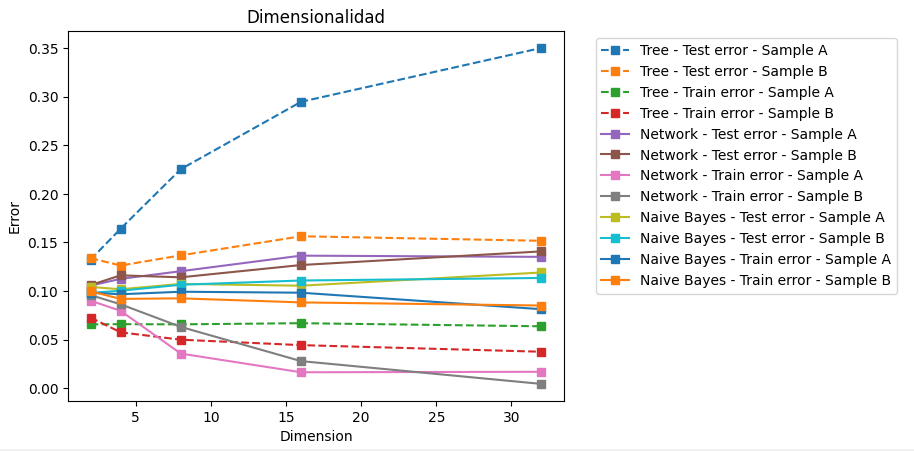

Lo que más vale la pena destacar es que los errores de test obtenidos con los clasificadores Naive Bayes son menores que los obtenidos con los otros modelos, para ambos problemas. Esto indicaría que este es el mejor modelo para resolver estos problemas, y siendo que las curvas de error son bastante constantes, diría que no es afectado por el aumento de dimensión.
Por otro lado, los errores de entrenamiento obtenidos con los clasificadores Naive Bayes son mayores que los errores de entrenamiento que logran los otros modelos. Esto resulta extraño en una primera instancia, pero analizándolo un poco más, puede significar que estos modelos son menos propensos a sobreajustar, cosa que pareciera pasar en redes neuronales según aumenta la dimensión (se va vaciando el espacio), y, en menor medida, en árboles.

## Ejercicio 2

Se entrenan clasificadores Naive Bayes para resolver el problema de de las Dos Elipses y el problema de las Espirales Anidadas. Se grafican las predicciones de dichos clasificadores, la clasificación real y la predicción de los mismos problemas resultos con redes neuronales.

In [ ]:
import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from copy import deepcopy


def plot_errors(train_errors, test_errors, title):
  x_axis = range(len(train_errors))
  plt.plot(x_axis, train_errors, label="Train Error")
  plt.plot(x_axis, test_errors, label="Test Error")
  plt.xlabel("Epochs")
  plt.ylabel("Error")
  plt.title(title)
  plt.legend()
  plt.show()


def plot_dataframe(dataframe, title):
	colors = dataframe["Class"].map({0: 'b', 1: 'r'})
	dataframe.plot(x="X", y="Y", kind='scatter', c=colors)
	plt.title(title)
	plt.show()


def limites_del_clasificador_1():
  dos_elipses_data_url = 'https://github.com/inescipullo/IAA/raw/main/TP2/Datasets/dos_elipses.data'
  dos_elipses_test_url = 'https://github.com/inescipullo/IAA/raw/main/TP2/Datasets/dos_elipses.test'

  columns = ['X','Y','Class']
  data_columns = columns[:-1]
  target_columns = columns[-1]

  dos_elipses_data_df = pd.read_csv(dos_elipses_data_url, header=None, names=columns, nrows=500)
  dos_elipses_test_df = pd.read_csv(dos_elipses_test_url, header=None, names=columns)
  X_test, y_test = dos_elipses_test_df[data_columns], dos_elipses_test_df[target_columns]
  X_train, y_train = dos_elipses_data_df[data_columns], dos_elipses_data_df[target_columns]

  clf = GaussianNB()
  clf.fit(X_train, y_train)
  y_test_pred = clf.predict(X_test)

  title = f"Prediction of Dos Elipses with Naive Bayes."
  test_df_with_prediction = pd.DataFrame({'X': X_test['X'], 'Y': X_test['Y'], 'Class':y_test_pred}, columns=columns)
  plot_dataframe(test_df_with_prediction, title)
  plot_dataframe(pd.DataFrame({'X': X_test['X'], 'Y': X_test['Y'], 'Class':y_test}), 'Actual test result of Dos Elipses')


def limites_del_clasificador_2():
  espirales_anidadas_data_url = 'https://github.com/inescipullo/IAA/raw/main/TP3/Datasets/espirales_anidadas.data'
  espirales_anidadas_test_url = 'https://github.com/inescipullo/IAA/raw/main/TP3/Datasets/espirales_anidadas.test'

  columns = ['X','Y','Class']
  data_columns = columns[:-1]
  target_columns = columns[-1]

  espirales_anidadas_data_df = pd.read_csv(espirales_anidadas_data_url, header=0, names=['Index']+columns, usecols=columns)
  espirales_anidadas_test_df = pd.read_csv(espirales_anidadas_test_url, header=0, names=['Index']+columns, usecols=columns)
  X_test, y_test = espirales_anidadas_test_df[data_columns], espirales_anidadas_test_df[target_columns]
  X_train, y_train = espirales_anidadas_data_df[data_columns], espirales_anidadas_data_df[target_columns]

  clf = GaussianNB()
  clf.fit(X_train, y_train)
  y_test_pred = clf.predict(X_test)

  title = f"Prediction of Espirales Anidadas with Naive Bayes."
  test_df_with_prediction = pd.DataFrame({'X': X_test['X'], 'Y': X_test['Y'], 'Class':y_test_pred}, columns=columns)
  plot_dataframe(test_df_with_prediction, title)
  plot_dataframe(pd.DataFrame({'X': X_test['X'], 'Y': X_test['Y'], 'Class':y_test}), 'Actual test result of Espirales Anidadas')


limites_del_clasificador_1()
limites_del_clasificador_2()

### Resultados Espirales Anidadas


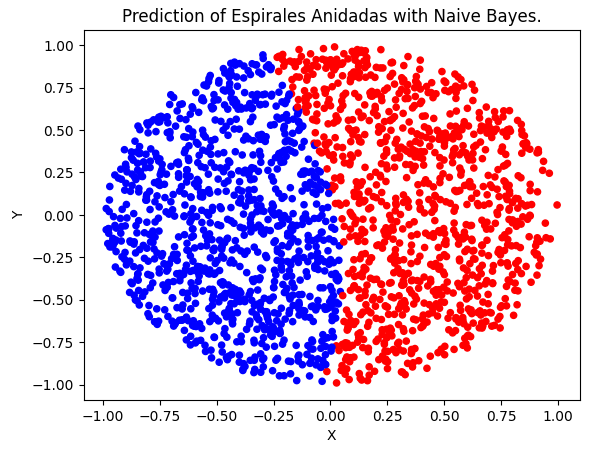

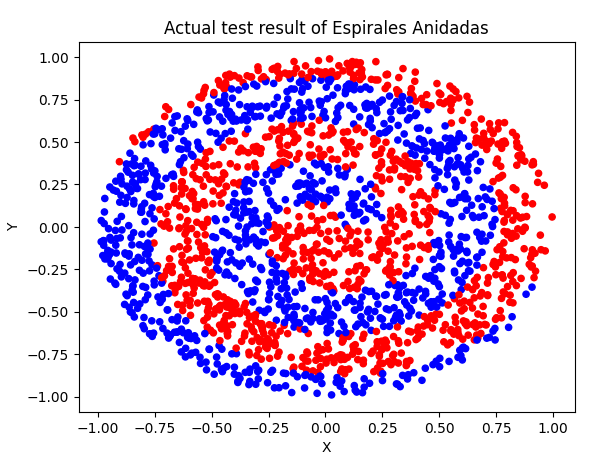

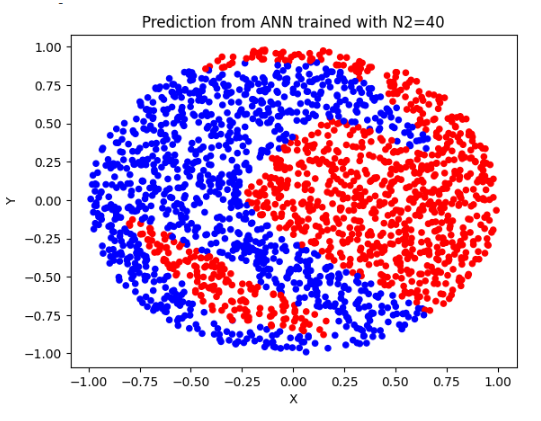


Observamos que la predicción de las espirales anidadas obtenida con el clasificador de Naive Bayes practicamente divide al plano a la mitad de forma casi paralela al eje `y` y clasifica cada lado con una clase distinta, lo cual resulta muy similar a una clasificación aleatoria (en error). Mientras que la red neuronal, si bien tampoco logra aproximar las espirales anidadas, las predice de manera acertada en algunos sectores, logrando menor error. En general, diría que ninguno de los dos modelos es el adecuado para este problema.  

### Resultados Dos Elipses


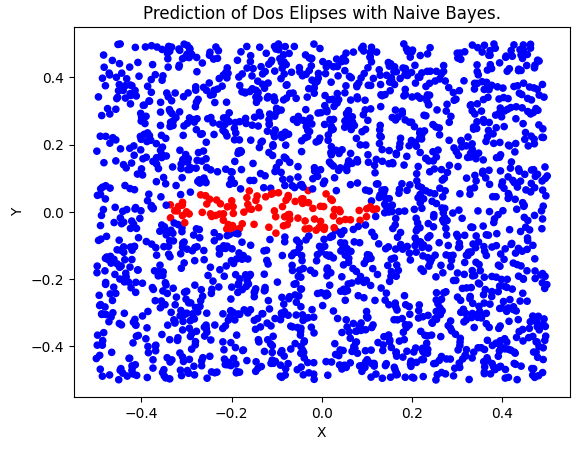

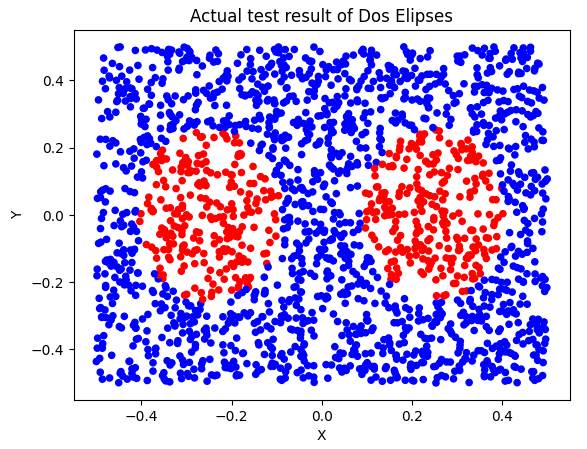

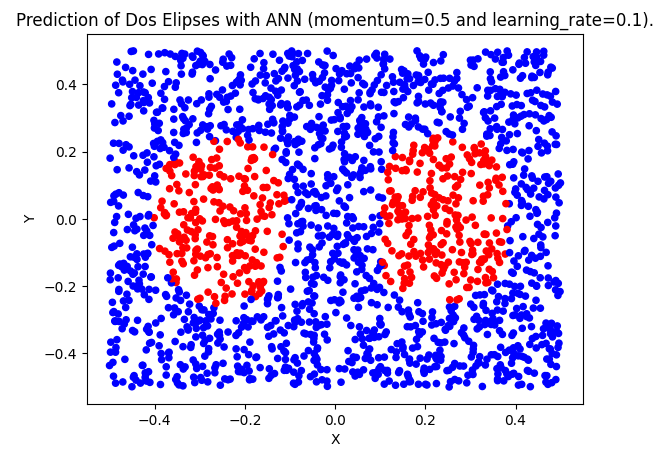

La mejor red neuronal que se obtiene variando `momentum` y `learning_rate` predice con un error mínimo el problema de las dos elipses. Comparando con la clasificación correcta, a simple vista se distinguen solo unos pocos puntos que la red clasificó mal. Mientras que la predicción del modelo de Naive Bayes ni se acerca a una correcta clasificación y ni siquiera pudo advertir que las elipses son dos conjuntos de puntos separados. Una razón para que esto ocurra puede ser porque el modelo de Naive Bayes asume independencia en la clasificación de los datos. Las redes neuronales son claramento el modelo correcto para este problema, al menos por sobre Naive Bayes.

## Ejercicio 3

Se define una función que tome los conjuntos de entrenamiento, validación y test, y los valores a probar del número de bins. La función tiene que convertir las variables continuas en categóricas (o sea, en un histograma) usando un discretizador y luego entrenar un clasificador Naive-Bayes con dicho histograma, usando un conjunto de validación para determinar el número óptimo de bins del histograma. Tiene que devolver los errores de entrenamiento, validación y test de acuerdo a la cantidad de bins, la cantidad óptima de bins, y el discretizador y el clasificador óptimos entrenados.

In [ ]:
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.naive_bayes import CategoricalNB
from copy import deepcopy


def train_categorical_NB(X_train, y_train, X_val, y_val, X_test, y_test, n_bins):
  train_errors = []
  val_errors = []
  test_errors = []
  best_val_error = 1

  for bins in n_bins:
    discretizador = KBinsDiscretizer(n_bins=bins, encode='ordinal', strategy='uniform')
    discretizador.fit(X_train)

    X_train_discreto = discretizador.transform(X_train.copy())
    X_val_discreto = discretizador.transform(X_val.copy())
    X_test_discreto = discretizador.transform(X_test.copy())

    clf = CategoricalNB(min_categories=bins)
    clf.fit(X_train_discreto, y_train)

    y_train_pred = clf.predict(X_train_discreto)
    y_val_pred = clf.predict(X_val_discreto)
    y_test_pred = clf.predict(X_test_discreto)

    train_error = 1 - accuracy_score(y_train, y_train_pred)
    val_error = 1 - accuracy_score(y_val, y_val_pred)
    test_error = 1 - accuracy_score(y_test, y_test_pred)

    train_errors.append(train_error)
    test_errors.append(test_error)
    val_errors.append(val_error)

    if val_error < best_val_error:
      best_val_error = val_error
      best_bins = bins
      best_clf = deepcopy(clf)
      best_discretizador = deepcopy(discretizador)

  return train_errors, test_errors, val_errors, best_bins, best_clf, best_discretizador


## Ejercicio 4



Esta vez se entrenan clasificadores CategoricalNB con histogramas obtenidos discretizando variables continuas para resolver el problema de de las Dos Elipses y el problema de las Espirales Anidadas. Se utiliza un conjunto de validación para determinar el número óptimo de bins del histograma. Se grafican los errores de entrenamiento, validación y test según la cantidad de bins. Además, se grafican las predicciones sobre el conjunto de test de los clasificadores con la cantidad de bins óptima y la clasificación real.

In [ ]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from copy import deepcopy
import pandas as pd
from sklearn.metrics import accuracy_score


def plot_errors2(n_bins, train_errors, test_errors, val_errors, title):
  plt.plot(n_bins, train_errors, label="Train Error")
  plt.plot(n_bins, test_errors, label="Test Error")
  plt.plot(n_bins, val_errors, label="Validation Error")
  plt.xlabel("Bins")
  plt.ylabel("Error")
  plt.title(title)
  plt.legend()
  plt.show()


def dos_elipses_2():
  dos_elipses_data_url = 'https://github.com/inescipullo/IAA/raw/main/TP2/Datasets/dos_elipses.data'
  dos_elipses_test_url = 'https://github.com/inescipullo/IAA/raw/main/TP2/Datasets/dos_elipses.test'

  columns = ['X','Y','Class']
  data_columns = columns[:-1]
  target_columns = columns[-1]

  dos_elipses_data_df = pd.read_csv(dos_elipses_data_url, header=None, names=columns, nrows=500)
  dos_elipses_test_df = pd.read_csv(dos_elipses_test_url, header=None, names=columns)
  X_test, y_test = dos_elipses_test_df[data_columns], dos_elipses_test_df[target_columns]
  X, y = dos_elipses_data_df[data_columns], dos_elipses_data_df[target_columns]
  X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=0, train_size=0.75)

  n_bins = range(2,100,2)

  train_errors, test_errors, val_errors, best_bins, best_clf, best_discretizador = train_categorical_NB(X_train, y_train, X_val, y_val, X_test, y_test, n_bins)

  plot_errors2(n_bins, train_errors, test_errors, val_errors, "Errors from CategoricalNB model varying by bins amount for Dos Elipses")

  X_test_discreto = best_discretizador.transform(X_test.copy())
  y_test_pred = best_clf.predict(X_test_discreto)

  title = f"Prediction of Dos Elipses with CategoricalNB (bins={best_bins})."
  test_df_with_prediction = pd.DataFrame({'X': X_test['X'], 'Y': X_test['Y'], 'Class':y_test_pred}, columns=columns)
  plot_dataframe(test_df_with_prediction, title)
  plot_dataframe(pd.DataFrame({'X': X_test['X'], 'Y': X_test['Y'], 'Class':y_test}), 'Actual test result of Dos Elipses')


def espirales_anidadas_2():
  espirales_anidadas_data_url = 'https://github.com/inescipullo/IAA/raw/main/TP3/Datasets/espirales_anidadas.data'
  espirales_anidadas_test_url = 'https://github.com/inescipullo/IAA/raw/main/TP3/Datasets/espirales_anidadas.test'

  columns = ['X','Y','Class']
  data_columns = columns[:-1]
  target_columns = columns[-1]

  espirales_anidadas_data_df = pd.read_csv(espirales_anidadas_data_url, header=0, names=['Index']+columns, usecols=columns)
  espirales_anidadas_test_df = pd.read_csv(espirales_anidadas_test_url, header=0, names=['Index']+columns, usecols=columns)
  X_test, y_test = espirales_anidadas_test_df[data_columns], espirales_anidadas_test_df[target_columns]
  X, y = espirales_anidadas_data_df[data_columns], espirales_anidadas_data_df[target_columns]
  X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=0, train_size=0.75)

  n_bins = range(2,100,2)

  train_errors, test_errors, val_errors, best_bins, best_clf, best_discretizador = train_categorical_NB(X_train, y_train, X_val, y_val, X_test, y_test, n_bins)

  plot_errors2(n_bins, train_errors, test_errors, val_errors, "Errors from CategoricalNB model varying by bins amount for Espirales Anidadas")

  X_test_discreto = best_discretizador.transform(X_test.copy())
  y_test_pred = best_clf.predict(X_test_discreto)

  title = f"Prediction of Espirales Anidadas with CategoricalNB (bins={best_bins})."
  test_df_with_prediction = pd.DataFrame({'X': X_test['X'], 'Y': X_test['Y'], 'Class':y_test_pred}, columns=columns)
  plot_dataframe(test_df_with_prediction, title)
  plot_dataframe(pd.DataFrame({'X': X_test['X'], 'Y': X_test['Y'], 'Class':y_test}), 'Actual test result of Espirales Anidadas')


dos_elipses_2()
espirales_anidadas_2()

### Resultados Espirales Anidadas


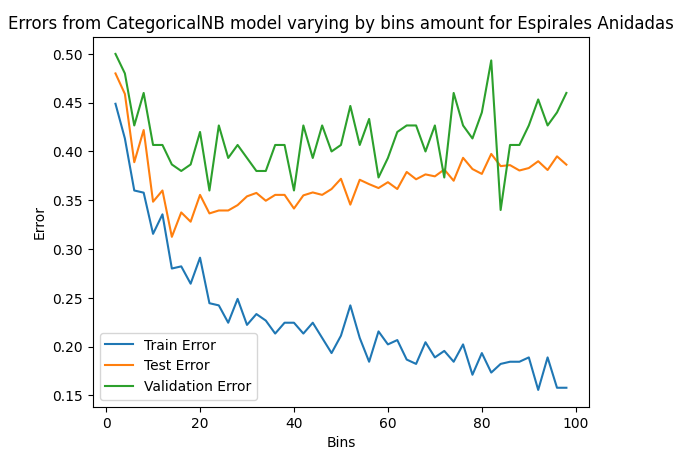

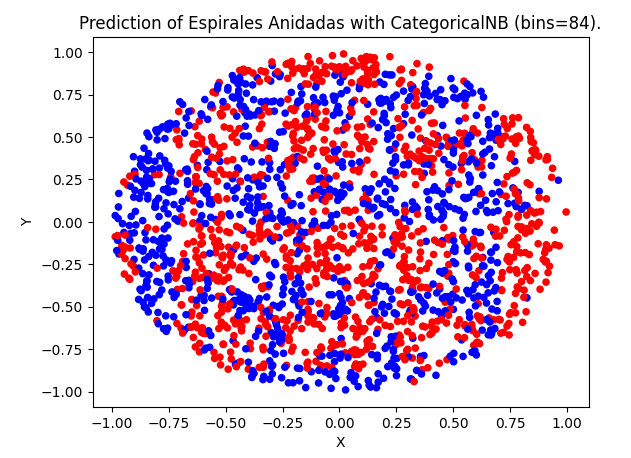

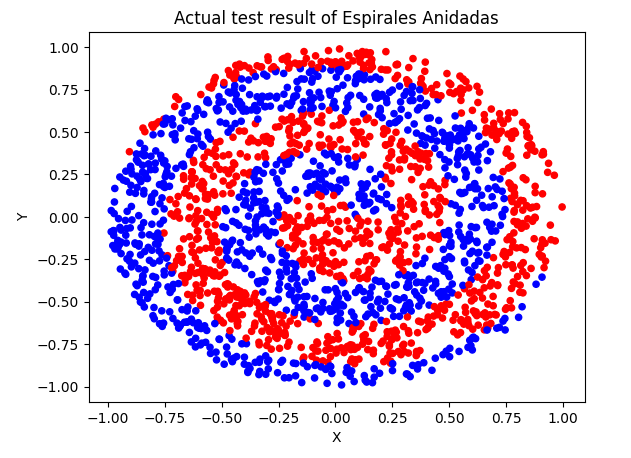

Por la gráfica de los errores según la cantidad de bins, vemos que el modelo CategorcalNB claramente se sobreajusta en este problema, obteniendo errores de entrenamiento cada vez menores, pero errores de test y validación cada vez mayores.

En el gráfico de la predicción del "mejor" modelo, vemos que los puntos parecen clasificados de forma practicamente aleatorea, lo cual resulta similar a lo obtenido en el ejercicio 2 (en cuanto al error, que en la gráfica de errores podemos ver que es casi 0.4 para este caso). Si bien se logran mejores errores de test con otras cantidades de bins, se toma como óptimo el modelo con menor error de validación, que por un pico hacia abajo del error de validación, resulta no siendo realmente el mejor modelo.

### Resultados Dos Elipses

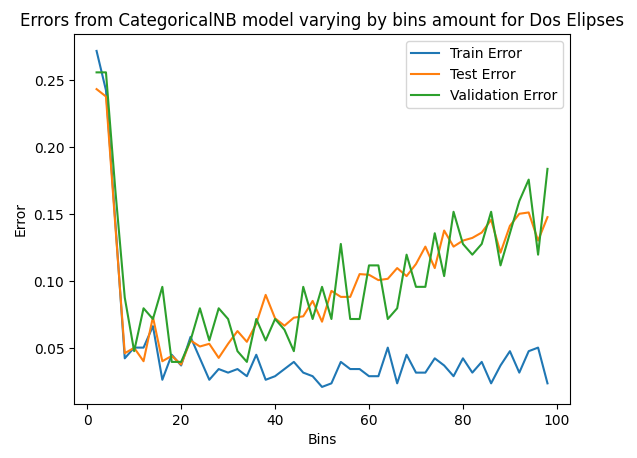

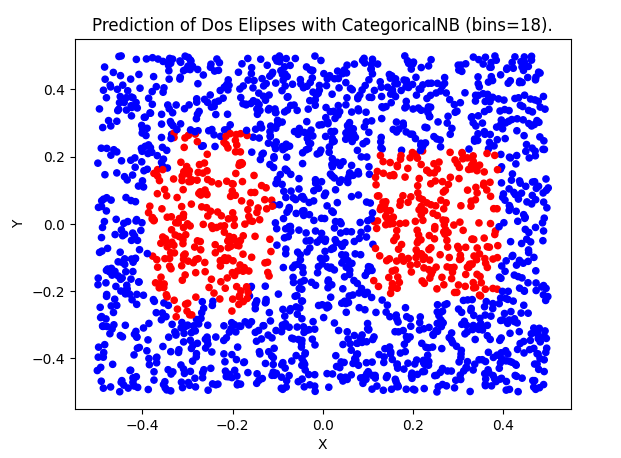

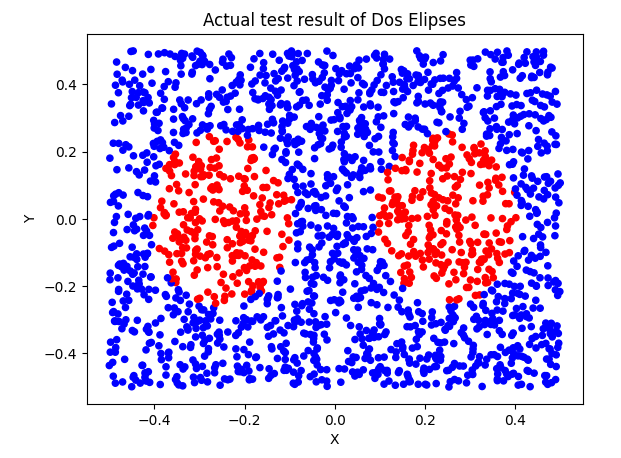

Para el problema de dos elipses la situación cambia. Los errores son mucho más bajos desde un principio, aunque también pareciera que termina sobreajustando ya que los errores de test y validación terminan aumentando significativamente.

En la gráfica de la clasificación vemos que se forman las dos elipses y solo hay errores de clasificación en los bordes de las elipses, es decir, en el limite entre una clase y la otra. Este modelo resulto considerablemente mejor para este problema que el del ejercicio 2, que no había logrado resultados significativos.

## Ejercicio 5

Un uso común del clasificador Naive Bayes es para clasificar texto. Se descarga un data set, se vectoriza, se clasifica con el clasificador discreto multinomial y se evalúa sobre los conjuntos de validación y test. Se prueban distintas combinaciones del largo del diccionario de palabras (1000, 2000, 3000 y 4000) y del parámetro alfa (1, 0.1, 0.01, 0.001, 0.0001), buscando el mínimo en validación. Luego se calcula una matriz de confusión para el conjunto de test utilizando la mejor predicción.

In [ ]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from copy import deepcopy
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
import pandas as pd
import matplotlib.pyplot as plt


def clasificacion_texto_vectorizado():
  X, y = fetch_20newsgroups(subset="train",return_X_y=True, remove=["headers"])
  X_train, X_val, y_train, y_val = train_test_split(X, y,test_size=0.25, random_state=1)
  X_test, y_test = fetch_20newsgroups(subset="test",return_X_y=True,remove=["headers"])

  best_val_error = 1
  table = []

  for largo_diccionario in range(1000, 5000, 1000):
    for alfa in [1, 0.1, 0.01, 0.001, 0.0001]:

      vec = CountVectorizer(stop_words='english',max_features=largo_diccionario)
      Xvec_train = vec.fit_transform(X_train).toarray()
      Xvec_val = vec.transform(X_val).toarray()
      Xvec_test = vec.transform(X_test).toarray()

      clf = MultinomialNB(alpha=alfa)
      clf.fit(Xvec_train, y_train)

      y_train_pred = clf.predict(Xvec_train)
      y_val_pred = clf.predict(Xvec_val)
      y_test_pred = clf.predict(Xvec_test)

      train_error = 1 - accuracy_score(y_train, y_train_pred)
      val_error = 1 - accuracy_score(y_val, y_val_pred)
      test_error = 1 - accuracy_score(y_test, y_test_pred)

      table.append([largo_diccionario, alfa, train_error, val_error, test_error])

      if val_error < best_val_error:
        best_val_error = val_error
        best_largo_diccionario = largo_diccionario
        best_alfa = alfa
        best_y_test_pred = deepcopy(y_test_pred)

  print(f"Modelo óptimo según error de validación: largo_diccionario={best_largo_diccionario} y alfa={best_alfa}")
  table_df = pd.DataFrame(table, columns=["Largo Diccionario", "Alfa", "Train Error", "Validation Error", "Test Error"])
  display(table_df)

  _, ax = plt.subplots(figsize=(10, 10))
  ConfusionMatrixDisplay.from_predictions(y_true=y_test, y_pred=best_y_test_pred, ax=ax)

clasificacion_texto_vectorizado()


### Resultados

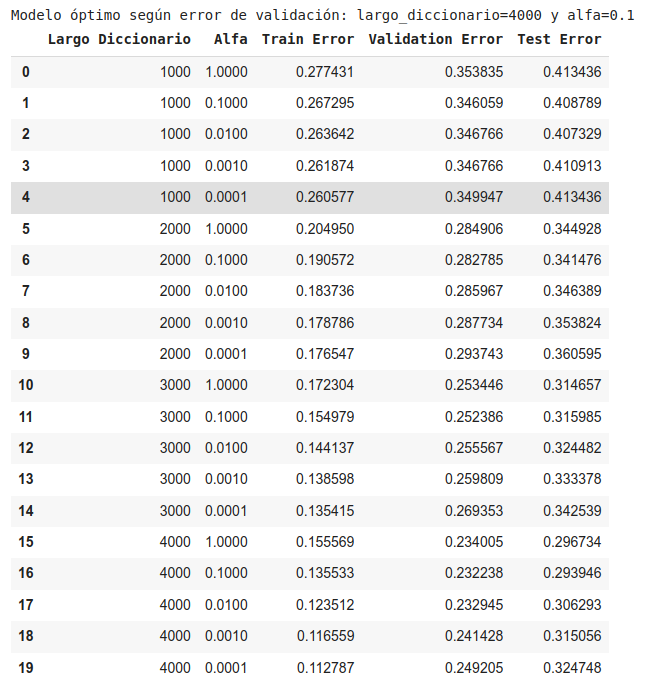

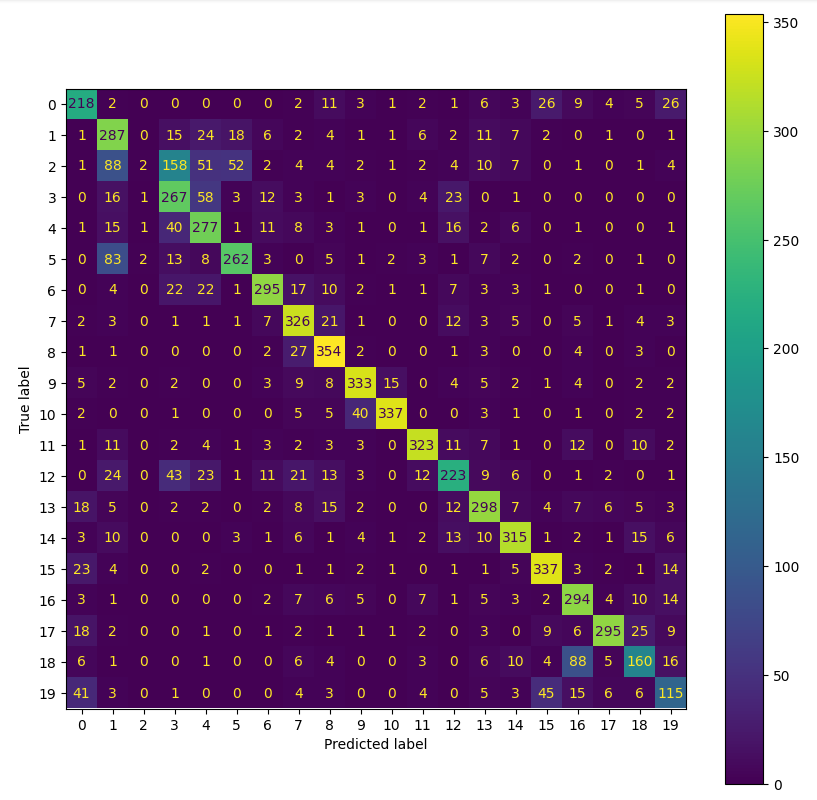

Según aumenta el largo de diccionario y diminuye el valor de alfa, el error de entrenamiento disminuye. No se puede decir lo mismo para los errores de test y validación, que si bien bajan según aumenta el largo del diccionario, tienden a aumentar según diminuye el valor de alfa. De esto deduciria que hay una leve tendencia a sobreajuste según aumenta alfa, y que el error de validación es totalmente representativo del error de test.

En cuanto a la matríz de confusión, lo que más llama la atención es que practicamente todos los datos de la clase 2 fueron mal clasificados, y es la única clase en la que paso eso. Lo único que se me ocurre es que estos datos pueden ser similares a los datos de otras clases en los atributos que luego se utilizan para clasificarlos y por eso no se los diferencia.